<a href="https://colab.research.google.com/github/Andrea-1704/Pytorch_Geometric_tutorial/blob/main/train_model_baseline_f1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In questo netebook proviamo ad implementare un processo di **pre gtraining** basato su self supervision tramite un task di edge prediction. L'obiettivo sarà quello di migliorare la capacità cognitiva dei dettagli strutturali della rete neurale. In pratica andremo a rimuovere dal grafo alcuni archi o aggiungerne altri e miglioreremo la capacità della rete nel riconoscere gli archi falsi e quelli mancanti.

In [32]:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-geometric==2.6.0 -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install pyg-lib -f https://data.pyg.org/whl/torch-2.4.0+cpu.html

# !pip install pytorch_frame[full]==1.2.2
# !pip install relbench[full]==1.0.0
# !pip uninstall -y pyg_lib torch  # Uninstall current versions
# !pip install torch==2.6.0  # Reinstall your desired PyTorch version
# !pip install --no-cache-dir git+https://github.com/pyg-team/pyg-lib.git # Install pyg-lib; --no-cache-dir ensures a fresh install

New libraries to run on colab:

In [33]:
# !pip install torch==2.6.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# !pip install pyg-lib -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-geometric==2.6.0 -f https://data.pyg.org/whl/torch-2.6.0+cu118.html

# !pip install pytorch_frame[full]==1.2.2
# !pip install relbench[full]==1.0.0

In [34]:
import os
import torch
import relbench
import numpy as np
from torch.nn import BCEWithLogitsLoss, L1Loss
from relbench.datasets import get_dataset
from relbench.tasks import get_task
import math
from tqdm import tqdm
import torch_geometric
import torch_frame
from torch_geometric.seed import seed_everything
from relbench.modeling.utils import get_stype_proposal
from collections import defaultdict
import requests
from io import StringIO
from torch_frame.config.text_embedder import TextEmbedderConfig
from relbench.modeling.graph import make_pkey_fkey_graph
from torch.nn import BCEWithLogitsLoss
import copy
from typing import Any, Dict, List
from torch import Tensor
from torch.nn import Embedding, ModuleDict
from torch_frame.data.stats import StatType
from torch_geometric.data import HeteroData
from torch_geometric.nn import MLP
from torch_geometric.typing import NodeType
from relbench.modeling.nn import HeteroEncoder, HeteroGraphSAGE, HeteroTemporalEncoder
from relbench.modeling.graph import get_node_train_table_input, make_pkey_fkey_graph
from torch_geometric.loader import NeighborLoader
import pyg_lib
from sklearn.metrics import mean_squared_error
#per lo scheduler
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch import nn
from torch_geometric.nn import Linear
from torch_geometric.utils import softmax
from torch_geometric.utils import degree
from collections import defaultdict

# Dataset and task creation

In [35]:
dataset = get_dataset("rel-f1", download=True)
task = get_task("rel-f1", "driver-position", download=True)

train_table = task.get_table("train")
val_table = task.get_table("val")
test_table = task.get_table("test")

out_channels = 1
# one because we are estimating one single value.
loss_fn = L1Loss()
# this is the mae loss and is used when have regressions tasks.
tune_metric = "mae"
higher_is_better = False

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
root_dir = "./data"

db = dataset.get_db()
col_to_stype_dict = get_stype_proposal(db)
#this is used to get the stype of the columns

cuda


# Embedder

In [36]:
# import torch
# from typing import List, Optional
# from sentence_transformers import SentenceTransformer
# from torch import Tensor


# class GloveTextEmbedding:
#     def __init__(self, device: Optional[torch.device
#                                        ] = None):
#         self.model = SentenceTransformer(
#             "sentence-transformers/average_word_embeddings_glove.6B.300d",
#             device=device,
#         )

#     def __call__(self, sentences: List[str]) -> Tensor:
#         return torch.from_numpy(self.model.encode(sentences))


class LightweightGloveEmbedder:
    def __init__(self, device=None):
        self.device = device
        self.embeddings = defaultdict(lambda: np.zeros(300))
        self._load_embeddings()

    def _load_embeddings(self):
        try:
            #(senza bisogno di estrarre zip
            url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.300d.txt"
            response = requests.get(url)
            response.raise_for_status()

            for line in StringIO(response.text):
                parts = line.split()
                word = parts[0]
                vector = np.array(parts[1:], dtype=np.float32)
                self.embeddings[word] = vector
        except Exception as e:
            print(f"Warning: Couldn't load GloVe embeddings ({str(e)}). Using zero vectors.")

    def __call__(self, sentences):
        results = []
        for text in sentences:
            words = text.lower().split()
            vectors = [self.embeddings[w] for w in words if w in self.embeddings]
            if vectors:
                avg_vector = np.mean(vectors, axis=0)
            else:
                avg_vector = np.zeros(300)
            results.append(avg_vector)

        tensor = torch.tensor(np.array(results), dtype=torch.float32)
        return tensor.to(self.device) if self.device else tensor

In [37]:
text_embedder_cfg = TextEmbedderConfig(
    text_embedder=LightweightGloveEmbedder(device=device), batch_size=256
)

data, col_stats_dict = make_pkey_fkey_graph(
    #Solution if not working: !pip install --upgrade torch torchvision transformers
    db,
    col_to_stype_dict=col_to_stype_dict,  # speficied column types
    text_embedder_cfg=text_embedder_cfg,  # our chosen text encoder
    cache_dir=os.path.join(
        root_dir, f"rel-f1_materialized_cache"
    ),  # store materialized graph for convenience
)# create a graph how relbench requires.

/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-pac

In [38]:
loader_dict = {}

for split, table in [
    ("train", train_table),
    ("val", val_table),
    ("test", test_table),
]:
    table_input = get_node_train_table_input(
        table=table,
        task=task,
    )#notice that table_input is an object with three elements: nodes, time and transform.
    #nodes contains the input nodes
    #time contains the time for each node
    #transform is the tranformation to be applied to nodes
    entity_table = table_input.nodes[0]
    #we need to populate the loader_dict with three elements: "train", "val", and "test".
    loader_dict[split] = NeighborLoader(
        data,
        num_neighbors=[
            128 for i in range(2)
        ],  # we sample subgraphs of depth 2, 128 neighbors per node.
        time_attr="time",
        input_nodes=table_input.nodes,
        input_time=table_input.time,
        transform=table_input.transform,
        batch_size=512,
        temporal_strategy="uniform",
        shuffle=split == "train",
        num_workers=0,
        persistent_workers=False,
    )#this is the loader for grapg

Nota che ogni oggetto "batch" rappresenta un dizionario in cui le chiavi rappresentano i tipi di nodi oppure i tipi di archi e contengono gli embedding del nodo opppure l'edge index dell'arco (vale a dire un tensore di dimensione 2xnumero di edge, ovvero la lista dei nodi di tipo sorgente che presdentano una relazione di quel tipo con i nodi di tipo destinazione, ovvero quelli della seconda lista).

# Pre-training

In [ ]:
def sample_edge_prediction_batch(batch: HeteroData, edge_type, neg_ratio=1.0):

    #prendiamo gli archi positivi, ovvero quelli che esistono davvero:
    pos_edge_index = batch[edge_type].edge_index
    num_pos = pos_edge_index.size(1)

    if num_pos == 0:
        #se non abbiamo archi positivie saltimao il batch
        raise ValueError(f"No positive edges found in batch for edge_type {edge_type}")

    #prendiamo ora i sample negativi: archi che non esistono nel grafo
    src, dst = pos_edge_index[0], pos_edge_index[1]
    neg_src = src[torch.randint(0, src.size(0), (int(num_pos * neg_ratio),))]
    neg_dst = dst[torch.randint(0, dst.size(0), (int(num_pos * neg_ratio),))]
    #nota potremmo averere come negativi degli archi che in realtà sono positivi
    pos_labels = torch.ones(num_pos, device=src.device)
    neg_labels = torch.zeros(neg_src.size(0), device=src.device)

    edge_src = torch.cat([src, neg_src], dim=0)
    edge_dst = torch.cat([dst, neg_dst], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    return edge_src, edge_dst, labels


Restituisce edge_src che è il tensore degli id dei nodi sorgenti per gli archi positivi e per quelli negativi; edge_dst che è il tensore degli archi destinazione sia positivi che negativi e labels che è un tensore di uni e zeri per dire se positivo o negativo.

Adeso andiamo ad implementare un modello che verrà utilizzato per effettuare il processo di **edge prediction**, ovvero il pre training al fine di inizializzare in maniera "intelligente" i pesi della rete.

Adesso necessitiamo di definire un metodo che effettui il processo di pre training, sarebbe quindi come definire un codice alternativo di training per un task differente (quello di link prediction) questo modello verà poi raffinato tramite un processo di trainig per il downstream task (quello effettivo di relbench).

In [40]:
def pretrain_edge_prediction(model, loader, edge_type, optimizer, epochs=10):
    model.train()
    loss_fn = torch.nn.BCEWithLogitsLoss()
    #non lavora male per il task che dobbiamo effettuare sugli archi visto
    #che effettuiamo un task di predizione binaria (link presente o meno)

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            logits, labels = model(batch, edge_type)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}, Loss: {total_loss / len(loader):.4f}")


# Model

In [41]:
_spatial_bias_cache = None
_node_offset_cache = None
from collections import defaultdict


def compute_spatial_bias(edge_index_dict, x_dict):
    global _spatial_bias_cache, _node_offset_cache
    if _spatial_bias_cache is not None:
        return _spatial_bias_cache, _node_offset_cache
    #creiamo un grafo diretto con Networkx
    G = nx.DiGraph()

    node_offset = {}
    curr_offset = 0

    #aggiungiamo i nodi con offset per mantenere indici globali univoci
    for node_type, x in x_dict.items():
        node_offset[node_type] = curr_offset
        for i in range(x.size(0)):
            G.add_node(curr_offset + i, type=node_type)
        curr_offset += x.size(0)

    #Aggiungiamo gli archi con offset
    for (src_type, _, dst_type), edge_index in edge_index_dict.items():
        src_offset = node_offset[src_type]
        dst_offset = node_offset[dst_type]
        src, dst = edge_index
        for s, d in zip(src.tolist(), dst.tolist()):
            G.add_edge(src_offset + s, dst_offset + d)


    spatial_bias = defaultdict(lambda: -1)



    for node in G.nodes():
        lengths = nx.single_source_dijkstra_path_length(G, node)
        for target, dist in lengths.items():
            spatial_bias[(node, target)] = dist
        #quelli non raggiungibili li lasciamo con default value, ovvero -1

    _spatial_bias_cache = spatial_bias
    _node_offset_cache = node_offset

    return spatial_bias, node_offset

In [42]:
class HeteroGraphormerLayerComplete(nn.Module):
    def __init__(self, channels, edge_types, device, num_heads=4, dropout=0.1):
        super().__init__()
        self.device = device
        self.num_heads = num_heads
        self.channels = channels
        self.head_dim = channels // num_heads

        assert self.channels % num_heads == 0, "channels must be divisible by num_heads"

        self.q_lin = Linear(channels, channels)
        self.k_lin = Linear(channels, channels)
        self.v_lin = Linear(channels, channels)
        self.out_lin = Linear(channels, channels)

        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(channels)

        # Registriamo i bias per ogni tipo di edge nel __init__
        self.edge_type_bias = nn.ParameterDict({
            "__".join(edge_type): nn.Parameter(torch.randn(1))
            for edge_type in edge_types
        })

    def compute_total_degrees(self, x_dict, edge_index_dict):
        device = self.device
        in_deg = defaultdict(lambda: torch.zeros(0, device=device))
        out_deg = defaultdict(lambda: torch.zeros(0, device=device))
        for edge_type, edge_index in edge_index_dict.items():
            src_type, _, dst_type = edge_type
            src = edge_index[0]
            dst = edge_index[1]

            num_src = x_dict[src_type].size(0)
            num_dst = x_dict[dst_type].size(0)

            if out_deg[src_type].numel() == 0:
                out_deg[src_type] = torch.zeros(num_src, device=device)
            if in_deg[dst_type].numel() == 0:
                in_deg[dst_type] = torch.zeros(num_dst, device=device)

            out_deg[src_type] += degree(src, num_nodes=num_src)
            in_deg[dst_type]  += degree(dst, num_nodes=num_dst)

        total_deg = {
            node_type: in_deg[node_type] + out_deg[node_type]
            for node_type in x_dict
        }

        return total_deg

    def forward(self, x_dict, edge_index_dict):
        #print(edge_index_dict)
        self.spatial_bias, self.node_offset = compute_spatial_bias(edge_index_dict, x_dict)

        out_dict = {k: torch.zeros_like(v) for k, v in x_dict.items()}
        for edge_type, edge_index in edge_index_dict.items():
            src_type, _, dst_type = edge_type
            x_src, x_dst = x_dict[src_type], x_dict[dst_type]

            #src, dst = edge_index
            src = edge_index[0]
            dst = edge_index[1]

            Q = self.q_lin(x_dst).view(-1, self.num_heads, self.head_dim)
            K = self.k_lin(x_src).view(-1, self.num_heads, self.head_dim)
            V = self.v_lin(x_src).view(-1, self.num_heads, self.head_dim)

            attn_scores = (Q[dst] * K[src]).sum(dim=-1) / self.head_dim**0.5
            src_offset = self.node_offset[src_type]
            dst_offset = self.node_offset[dst_type]

            spatial_bias_vals = []
            for s, d in zip(src.tolist(), dst.tolist()):
                global_s = src_offset + s
                global_d = dst_offset + d
                dist = self.spatial_bias.get((global_d, global_s), -1.0)
                spatial_bias_vals.append(dist)

            spatial_bias_tensor = torch.tensor(spatial_bias_vals, dtype=torch.float, device=self.device)
            attn_scores = attn_scores + spatial_bias_tensor.unsqueeze(-1)  # broadcast su heads


            bias_name = "__".join(edge_type)
            attn_scores = attn_scores + self.edge_type_bias[bias_name]

            attn_weights = softmax(attn_scores, dst)
            attn_weights = self.dropout(attn_weights)

            out = V[src] * attn_weights.unsqueeze(-1)
            out = out.view(-1, self.channels)

            out_dict[dst_type].index_add_(0, dst, out)

        #calcolo della degree centrality

        total_deg = self.compute_total_degrees(x_dict, edge_index_dict)


        for node_type in out_dict:

            degree_embed = total_deg[node_type].view(-1, 1)                                                                                  # Assicurati che sia una colonna
            degree_embed = degree_embed.expand(-1, self.channels)                                                                            # Espandi lungo la dimensione dei canali


            out_dict[node_type] = out_dict[node_type] + degree_embed


        for node_type in out_dict:
            out_dict[node_type] = self.norm(out_dict[node_type] + x_dict[node_type])

        return out_dict


## HeteroGraphormer

In [43]:
class HeteroGraphormer(torch.nn.Module):
    def __init__(self, node_types, edge_types, channels, num_layers=2):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            HeteroGraphormerLayerComplete(channels, edge_types, device) for _ in range(num_layers)
        ])

    def forward(self, x_dict, edge_index_dict, *args, **kwargs):
        for layer in self.layers:
            x_dict = layer(x_dict, edge_index_dict)
        return x_dict

    def reset_parameters(self):
        for layer in self.layers:
            if hasattr(layer, "reset_parameters"):
                layer.reset_parameters()

In [44]:
class Model(torch.nn.Module):

    def __init__(
        self,
        data: HeteroData, #notice that "data2 is the graph we created with function make_pkey_fkey_graph
        col_stats_dict: Dict[str, Dict[str, Dict[StatType, Any]]],
        num_layers: int,
        channels: int,
        out_channels: int,
        aggr: str,
        norm: str,
        # List of node types to add shallow embeddings to input
        shallow_list: List[NodeType] = [],
        # ID awareness
        id_awareness: bool = False,
    ):
        super().__init__()

        self.encoder = HeteroEncoder(
            channels=channels,
            node_to_col_names_dict={
                node_type: data[node_type].tf.col_names_dict
                for node_type in data.node_types
            },
            node_to_col_stats=col_stats_dict,
        )
        self.temporal_encoder = HeteroTemporalEncoder(
            node_types=[
                node_type for node_type in data.node_types if "time" in data[node_type]
            ],
            channels=channels,
        )
        self.gnn = HeteroGraphormer(
            node_types=data.node_types,
            edge_types=data.edge_types,
            channels=channels,
            num_layers=num_layers,
        )
        self.head = MLP(
            channels,#one, since we are doing regression
            out_channels=out_channels,
            norm=norm,
            num_layers=1,
        )
        self.embedding_dict = ModuleDict(
            {
                node: Embedding(data.num_nodes_dict[node], channels)
                for node in shallow_list
            }
        )

        self.id_awareness_emb = None
        if id_awareness:
            self.id_awareness_emb = torch.nn.Embedding(1, channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.temporal_encoder.reset_parameters()
        self.gnn.reset_parameters()
        self.head.reset_parameters()
        for embedding in self.embedding_dict.values():
            torch.nn.init.normal_(embedding.weight, std=0.1)
        if self.id_awareness_emb is not None:
            self.id_awareness_emb.reset_parameters()

    def forward(
        self,
        batch: HeteroData,
        entity_table: NodeType,
    ) -> Tensor:
        seed_time = batch[entity_table].seed_time
        #takes the timestamp of the nodes for which we want to make predictions
        #not the neighbours, but the nodes we want to make prediction for.
        x_dict = self.encoder(batch.tf_dict)
        #this creates a dictionar for all the nodes: each nodes has its
        #embedding

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )
        #this add the temporal information to the node using the
        #HeteroTemporalEncoder

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time
        #add some other shallow embedder

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        # for edge_type, edge_index in batch.edge_index_dict.items():
        #     print("model edge_tipe: ", edge_type)
        #     print("model edge_index: ", edge_index)
        #print("model x_dict : ", x_dict['constructors'])

        x_dict = self.gnn(
            x_dict,#feature of nodes
            batch.edge_index_dict,
            batch.num_sampled_nodes_dict,
            batch.num_sampled_edges_dict,
        )#apply the gnn

        return self.head(x_dict[entity_table][: seed_time.size(0)])#final prediction

    def forward_dst_readout(
        self,
        batch: HeteroData,
        entity_table: NodeType,
        dst_table: NodeType,
    ) -> Tensor:
        if self.id_awareness_emb is None:
            raise RuntimeError(
                "id_awareness must be set True to use forward_dst_readout"
            )
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)
        # Add ID-awareness to the root node
        x_dict[entity_table][: seed_time.size(0)] += self.id_awareness_emb.weight

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        x_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
        )

        return self.head(x_dict[dst_table])


model = Model(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(device)

# Pre training Model

In [ ]:
class EdgePredictionModel(torch.nn.Module):
    def __init__(self, base_model: Model):
        super().__init__()
        self.model=base_model
        self.encoder = base_model.encoder
        self.temporal_encoder = base_model.temporal_encoder
        self.gnn = base_model.gnn

    def encode(self, batch: HeteroData) -> Dict[str, Tensor]:
        x_dict = self.encoder(batch.tf_dict)
        x_dict = self.gnn(x_dict, batch.edge_index_dict)
        return x_dict
    #ottiene gli embeddings dei nodi

    def decode(self, src_emb, dst_emb):
        return (src_emb * dst_emb).sum(dim=1)  #dot product, calcolo similarity
    #riceve gli embedding dei nodi sorgente e destinazione e calcola il prodotto 
    # scalare (dot product) tra le coppie → misura di similarità.
    # Questo è un logit che può essere passato a una BCEWithLogitsLoss 
    # per predizione binaria (edge presente o assente).

    def forward(self, batch: HeteroData, edge_type):
        x_dict = self.encode(batch)

        src, dst, labels = sample_edge_prediction_batch(batch, edge_type)

        src_emb = x_dict[edge_type[0]][src]#embeddings dei nodi sorgente
        dst_emb = x_dict[edge_type[2]][dst]#embeddings dei nodi destinazione
        logits = self.decode(src_emb, dst_emb)

        return logits, labels


# Scheduler

In [46]:
def get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * num_cycles * 2 * progress)))

    return LambdaLR(optimizer, lr_lambda)


In [47]:
def train(model, optimizer, scheduler) -> float:
    model.train()

    loss_accum = count_accum = 0
    for batch in tqdm(loader_dict["train"]):
        batch = batch.to(device)

        optimizer.zero_grad()
        pred = model(
            batch,
            task.entity_table,
        )
        pred = pred.view(-1) if pred.size(1) == 1 else pred

        loss = loss_fn(pred.float(), batch[entity_table].y.float())
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_accum += loss.detach().item() * pred.size(0)
        count_accum += pred.size(0)

    return loss_accum / count_accum


@torch.no_grad()
def test(model, loader: NeighborLoader) -> np.ndarray:
    model.eval()

    pred_list = []
    for batch in loader:
        batch = batch.to(device)
        pred = model(
            batch,
            task.entity_table,
        )
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred_list.append(pred.detach().cpu())
    return torch.cat(pred_list, dim=0).numpy()

In [48]:
def rmse(true, pred):
    """Calculate the Root Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean((true - pred)**2)) # Calculate RMSE manually

In [49]:
def custom_evaluate(pred: np.ndarray, target_table, metrics) -> dict:
    """Custom evaluation function to replace task.evaluate."""

    # Extract target values from the target table
    target = target_table.df[task.target_col].to_numpy()

    # Check for length mismatch
    if len(pred) != len(target):
        raise ValueError(
            f"The length of pred and target must be the same (got "
            f"{len(pred)} and {len(target)}, respectively)."
        )

    # Calculate metrics
    results = {}
    for metric_fn in metrics:
        if metric_fn.__name__ == "rmse":  # Handle RMSE specifically
            results["rmse"] = np.sqrt(np.mean((target - pred)**2))
        else:  # Handle other metrics (if any)
            results[metric_fn.__name__] = metric_fn(target, pred)

    return results

In [50]:
def training_function(model, optimizer, epochs):
    state_dict = None
    best_val_metric = -math.inf if higher_is_better else math.inf
    for epoch in range(1, epochs + 1):
        train_loss = train(model, optimizer)
        val_pred = test(model, loader_dict["val"])
        #val_metrics = task.evaluate(val_pred, val_table)
        val_metrics = custom_evaluate(val_pred, val_table, task.metrics)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch:02d}, Train loss: {train_loss}, Val metrics: {val_metrics}")
        #print(f"Epoch: {epoch:02d}, Train loss: {train_loss}, Val metrics: {val_metrics}")

        if (higher_is_better and val_metrics[tune_metric] > best_val_metric) or (
            not higher_is_better and val_metrics[tune_metric] < best_val_metric
        ):
            best_val_metric = val_metrics[tune_metric]
            state_dict = copy.deepcopy(model.state_dict())


    model.load_state_dict(state_dict)
    val_pred = test(model, loader_dict["val"])
    val_metrics = custom_evaluate(val_pred, val_table, task.metrics)
    print(f"Best Val metrics for parameters {optimizer}, are: {val_metrics}")

## Cross validation cycle

In [51]:
# #cross validation cycle:
# #possible learning rates: [0.01, 0.001, 0.0001, 0.00001]
# #possible batch sizes: [64, 256, 512]
# #possible number of layers: [1, 2, 3]
# #possible weight decay: [0.0001, 0.001, 0.01]

# for lr in [0.01, 0.001, 0.0001, 0.00001]:#0.001
#     #for batch_size in [64, 256, 512]:
#         for num_layers in [1, 2, 3]:#1
#             #for weight_decay in [0.0001, 0.001, 0.01]:
#                 model = Model(
#                     data=data,
#                     col_stats_dict=col_stats_dict,
#                     num_layers=num_layers,
#                     channels=128,
#                     out_channels=1,
#                     aggr="sum",
#                     norm="batch_norm",
#                 ).to(device)
#                 print(f"Training with lr={lr}, num_layers={num_layers}")
#                 optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
#                 training_function(model, optimizer, epochs=10) # Set epochs to a smaller number for testing

# Training

In [52]:
def plot_validation_metrics(metric_histories, model_names=None, metric_name="MAE", informationsTitle=""):
    """
    Plotta l'andamento del metric_name per più modelli nel tempo.

    Args:
        metric_histories (list of lists): Lista di liste, ognuna rappresenta i valori di metriche per un modello.
        model_names (list of str): Nomi dei modelli (opzionale).
        metric_name (str): Nome della metrica da visualizzare.
        informationsTitle (str): info aggiungitive da mettere nel titolo (conf generale dei parametri ecc).
    """
    plt.figure(figsize=(9, 5))

    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(metric_histories))]

    for metrics, name in zip(metric_histories, model_names):
        plt.plot(metrics, marker='o', label=f'{name} {metric_name}')

    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} over Epochs for Multiple Models {informationsTitle}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



Pretraining per edge_type: ('races', 'rev_f2p_raceId', 'standings')
Epoch 0, Loss: 4.3043
Epoch 1, Loss: 0.7483
Epoch 2, Loss: 0.3625
Epoch 3, Loss: 0.2449
Epoch 4, Loss: 0.1915
Epoch 5, Loss: 0.1621
Epoch 6, Loss: 0.1416
Epoch 7, Loss: 0.1264
Epoch 8, Loss: 0.1128
Epoch 9, Loss: 0.1028
Epoch 10, Loss: 0.0958
Epoch 11, Loss: 0.0899
Epoch 12, Loss: 0.0835
Epoch 13, Loss: 0.0783
Epoch 14, Loss: 0.0754
Epoch 15, Loss: 0.0717
Epoch 16, Loss: 0.0681
Epoch 17, Loss: 0.0656
Epoch 18, Loss: 0.0635
Epoch 19, Loss: 0.0609
Epoch 20, Loss: 0.0573
Epoch 21, Loss: 0.0554
Epoch 22, Loss: 0.0530
Epoch 23, Loss: 0.0498
Epoch 24, Loss: 0.0472
Epoch 25, Loss: 0.0438
Epoch 26, Loss: 0.0426
Epoch 27, Loss: 0.0400
Epoch 28, Loss: 0.0392
Epoch 29, Loss: 0.0363
Epoch 30, Loss: 0.0343
Epoch 31, Loss: 0.0328
Epoch 32, Loss: 0.0312
Epoch 33, Loss: 0.0301
Epoch 34, Loss: 0.0295
Epoch 35, Loss: 0.0279
Epoch 36, Loss: 0.0267
Epoch 37, Loss: 0.0255
Epoch 38, Loss: 0.0247
Epoch 39, Loss: 0.0243
Epoch 40, Loss: 0.023

100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch: 01, Train loss: 13.501905059200253, Val metrics: {'r2': -3.8737648024438336, 'mae': 9.117145528680656, 'rmse': np.float64(10.23487571431109)}


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Epoch: 02, Train loss: 10.709976612793811, Val metrics: {'r2': -1.8020707574187274, 'mae': 6.548875175321906, 'rmse': np.float64(7.7605024175174275)}


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch: 03, Train loss: 8.768892973041623, Val metrics: {'r2': -0.9809455419365389, 'mae': 5.447440596333965, 'rmse': np.float64(6.525090776159976)}


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


Epoch: 04, Train loss: 7.9322524421985685, Val metrics: {'r2': -0.6255501317425958, 'mae': 4.945211573991285, 'rmse': np.float64(5.910857282400424)}


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


Epoch: 05, Train loss: 7.32131954341803, Val metrics: {'r2': -0.35095667672763775, 'mae': 4.524334662264796, 'rmse': np.float64(5.3885386302398794)}


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch: 06, Train loss: 6.774766865055561, Val metrics: {'r2': -0.1418936916212432, 'mae': 4.180910639740581, 'rmse': np.float64(4.954081266830614)}


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


Epoch: 07, Train loss: 6.29888071579436, Val metrics: {'r2': -0.02055514905131539, 'mae': 3.9458744087295683, 'rmse': np.float64(4.68347847670755)}


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch: 08, Train loss: 5.917357801511338, Val metrics: {'r2': -0.007848938511352044, 'mae': 3.860449213143898, 'rmse': np.float64(4.6542318197792785)}


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


Epoch: 09, Train loss: 5.683574975872462, Val metrics: {'r2': -0.07978769548713682, 'mae': 3.927258692443888, 'rmse': np.float64(4.817475079452381)}


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


Epoch: 10, Train loss: 5.579096104112485, Val metrics: {'r2': -0.1694002924710818, 'mae': 4.03594890790696, 'rmse': np.float64(5.013394597493396)}


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch: 11, Train loss: 5.551196614000184, Val metrics: {'r2': -0.193352221528728, 'mae': 4.067492649152268, 'rmse': np.float64(5.064477110058386)}


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


Epoch: 12, Train loss: 5.527779751842524, Val metrics: {'r2': 0.029129928650970305, 'mae': 3.7468032334913155, 'rmse': np.float64(4.56804997354811)}


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch: 13, Train loss: 5.432874870095559, Val metrics: {'r2': 0.20229888980681188, 'mae': 3.426090200662453, 'rmse': np.float64(4.140667788628067)}


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


Epoch: 14, Train loss: 5.158427379474566, Val metrics: {'r2': 0.23598954100156555, 'mae': 3.2544849174056116, 'rmse': np.float64(4.052284623064642)}


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


Epoch: 15, Train loss: 5.036977721175523, Val metrics: {'r2': 0.15486716562026925, 'mae': 3.3557336040234356, 'rmse': np.float64(4.261993441428805)}


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


Epoch: 16, Train loss: 4.968900846951954, Val metrics: {'r2': 0.28160857436721975, 'mae': 3.1069664290051655, 'rmse': np.float64(3.929441790987855)}


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


Epoch: 17, Train loss: 4.847433478435893, Val metrics: {'r2': 0.29689500891938037, 'mae': 2.967132325640661, 'rmse': np.float64(3.8874102912375967)}


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


Epoch: 18, Train loss: 4.752716973853818, Val metrics: {'r2': 0.3083994431758186, 'mae': 2.9512050699375436, 'rmse': np.float64(3.855475580407936)}


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


Epoch: 19, Train loss: 4.7096456320801146, Val metrics: {'r2': 0.23241709338920835, 'mae': 3.180087206948178, 'rmse': np.float64(4.061747642189041)}


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch: 20, Train loss: 4.685452202638651, Val metrics: {'r2': 0.31596055470298745, 'mae': 2.9305273735770085, 'rmse': np.float64(3.8343421412543544)}


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch: 21, Train loss: 4.696372593455261, Val metrics: {'r2': 0.21457591926034314, 'mae': 3.176078492829062, 'rmse': np.float64(4.108680736019478)}


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


Epoch: 22, Train loss: 4.645947177922279, Val metrics: {'r2': 0.37030409158441024, 'mae': 2.764799352287848, 'rmse': np.float64(3.678880875463291)}


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


Epoch: 23, Train loss: 4.6416857517375, Val metrics: {'r2': 0.2515469737844137, 'mae': 3.0648975376773846, 'rmse': np.float64(4.010814385823332)}


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


Epoch: 24, Train loss: 4.597029735046186, Val metrics: {'r2': 0.3743878059393231, 'mae': 2.763497268444869, 'rmse': np.float64(3.666932302029147)}


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


Epoch: 25, Train loss: 4.592360770991868, Val metrics: {'r2': 0.3725078493087931, 'mae': 2.776788962994246, 'rmse': np.float64(3.672437711511744)}


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


Epoch: 26, Train loss: 4.571557973385433, Val metrics: {'r2': 0.11396191675166956, 'mae': 3.4297143214690187, 'rmse': np.float64(4.363917022148197)}


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


Epoch: 27, Train loss: 4.542882889625163, Val metrics: {'r2': 0.3103656128817327, 'mae': 2.95324237071122, 'rmse': np.float64(3.8499912624728716)}


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch: 28, Train loss: 4.504757937914123, Val metrics: {'r2': 0.37657071306431655, 'mae': 2.8121644745051424, 'rmse': np.float64(3.6605293199665803)}


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


Epoch: 29, Train loss: 4.501961780941184, Val metrics: {'r2': 0.3155604694350539, 'mae': 2.953968603290871, 'rmse': np.float64(3.8354633043435924)}


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


Epoch: 30, Train loss: 4.45504164097534, Val metrics: {'r2': 0.23918297033715374, 'mae': 3.095673937692432, 'rmse': np.float64(4.043806836393006)}


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


Epoch: 31, Train loss: 4.490570407257326, Val metrics: {'r2': 0.28442628900338063, 'mae': 3.0499135492002476, 'rmse': np.float64(3.921728082664911)}


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


Epoch: 32, Train loss: 4.433002250619691, Val metrics: {'r2': 0.2864600628212617, 'mae': 2.978690866318717, 'rmse': np.float64(3.916151030965729)}


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


Epoch: 33, Train loss: 4.4520677689112516, Val metrics: {'r2': 0.3534986083803695, 'mae': 2.865463597088077, 'rmse': np.float64(3.727649083676773)}


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


Epoch: 34, Train loss: 4.419386943874464, Val metrics: {'r2': 0.3448029719957776, 'mae': 2.9155757296937423, 'rmse': np.float64(3.7526343450318915)}


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Epoch: 35, Train loss: 4.41709830273754, Val metrics: {'r2': 0.36671069703384007, 'mae': 2.8593121548374256, 'rmse': np.float64(3.689362811457421)}


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch: 36, Train loss: 4.4345143338137785, Val metrics: {'r2': 0.3914236161446828, 'mae': 2.764516680290003, 'rmse': np.float64(3.6166612854787012)}


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Epoch: 37, Train loss: 4.4091636235324, Val metrics: {'r2': 0.32516728477149504, 'mae': 2.9289224734844646, 'rmse': np.float64(3.8084508390708383)}


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Epoch: 38, Train loss: 4.35618047299648, Val metrics: {'r2': 0.2555276578314737, 'mae': 3.117389078911098, 'rmse': np.float64(4.000134309970408)}


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


Epoch: 39, Train loss: 4.353179249430157, Val metrics: {'r2': 0.2600045986043571, 'mae': 3.0909741202910586, 'rmse': np.float64(3.9880886180367767)}


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


Epoch: 40, Train loss: 4.314565457674572, Val metrics: {'r2': 0.029820864164587402, 'mae': 3.574340503997777, 'rmse': np.float64(4.5664242206317125)}


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


Epoch: 41, Train loss: 4.352361529557702, Val metrics: {'r2': 0.2685885527970111, 'mae': 3.0905327461525527, 'rmse': np.float64(3.9648902120687133)}


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


Epoch: 42, Train loss: 4.303179187805368, Val metrics: {'r2': 0.26013109703829973, 'mae': 3.110930517282021, 'rmse': np.float64(3.987747731778994)}


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Epoch: 43, Train loss: 4.293987343267484, Val metrics: {'r2': 0.3324584425848305, 'mae': 2.9664389210218736, 'rmse': np.float64(3.7878209647724383)}


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


Epoch: 44, Train loss: 4.306149010752313, Val metrics: {'r2': 0.30989218770223337, 'mae': 2.974106690273654, 'rmse': np.float64(3.851312520616149)}


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


Epoch: 45, Train loss: 4.252359159805623, Val metrics: {'r2': 0.22315949715529082, 'mae': 3.1894574126165236, 'rmse': np.float64(4.086168015000594)}


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


Epoch: 46, Train loss: 4.261922763687291, Val metrics: {'r2': 0.30131189668021785, 'mae': 2.979145859334177, 'rmse': np.float64(3.8751807480222795)}


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


Epoch: 47, Train loss: 4.252069349210886, Val metrics: {'r2': 0.28313516537721306, 'mae': 3.024876239384184, 'rmse': np.float64(3.9252645134681634)}


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


Epoch: 48, Train loss: 4.235647269164126, Val metrics: {'r2': 0.2467874463143297, 'mae': 3.150780112502889, 'rmse': np.float64(4.023546867555234)}


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch: 49, Train loss: 4.2289441709596485, Val metrics: {'r2': 0.2975366938331908, 'mae': 3.009947935676447, 'rmse': np.float64(3.885635974474506)}


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch: 50, Train loss: 4.207926737003385, Val metrics: {'r2': 0.17358190872273127, 'mae': 3.2999475161075273, 'rmse': np.float64(4.214540169704783)}


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


Epoch: 51, Train loss: 4.210454885837745, Val metrics: {'r2': 0.3005708484190289, 'mae': 3.0042961843028095, 'rmse': np.float64(3.8772352662648486)}


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch: 52, Train loss: 4.204692859897897, Val metrics: {'r2': 0.29009088081525536, 'mae': 3.0404399556164434, 'rmse': np.float64(3.9061747387939003)}


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


Epoch: 53, Train loss: 4.211000116434766, Val metrics: {'r2': 0.17582073355477057, 'mae': 3.310170851553291, 'rmse': np.float64(4.20882755499081)}


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


Epoch: 54, Train loss: 4.163125689135579, Val metrics: {'r2': 0.2913052257840144, 'mae': 3.022937324099646, 'rmse': np.float64(3.9028324279680118)}


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


Epoch: 55, Train loss: 4.15102468156885, Val metrics: {'r2': 0.2454198836070941, 'mae': 3.129265755817105, 'rmse': np.float64(4.027197867041868)}


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch: 56, Train loss: 4.130341848878593, Val metrics: {'r2': 0.312195500164683, 'mae': 2.956773958416406, 'rmse': np.float64(3.8448800544502526)}


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


Epoch: 57, Train loss: 4.135857281709828, Val metrics: {'r2': 0.20389098225622682, 'mae': 3.217773482380665, 'rmse': np.float64(4.13653364712508)}


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


Epoch: 58, Train loss: 4.142699304913636, Val metrics: {'r2': 0.23642696897004212, 'mae': 3.128704347448024, 'rmse': np.float64(4.051124405687005)}


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Epoch: 59, Train loss: 4.109323452258932, Val metrics: {'r2': 0.18814679578156457, 'mae': 3.2515026891717294, 'rmse': np.float64(4.177236307945493)}


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


Epoch: 60, Train loss: 4.102668542054521, Val metrics: {'r2': 0.1839643090771388, 'mae': 3.262359369589475, 'rmse': np.float64(4.187982580195146)}


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch: 61, Train loss: 4.094501357933955, Val metrics: {'r2': 0.2986256325701956, 'mae': 3.0102170841329166, 'rmse': np.float64(3.88262310494471)}


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


Epoch: 62, Train loss: 4.076662734868654, Val metrics: {'r2': 0.24721189505539332, 'mae': 3.098772207035888, 'rmse': np.float64(4.022413037499917)}


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Epoch: 63, Train loss: 4.061173449070617, Val metrics: {'r2': 0.30114410426288885, 'mae': 2.962575721199224, 'rmse': np.float64(3.87564603926481)}


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch: 64, Train loss: 4.070337723937112, Val metrics: {'r2': 0.25128154781913836, 'mae': 3.133368641118169, 'rmse': np.float64(4.0115255058777075)}


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


Epoch: 65, Train loss: 4.03379911485813, Val metrics: {'r2': 0.2574666717311399, 'mae': 3.061357596403133, 'rmse': np.float64(3.9949216428235417)}


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


Epoch: 66, Train loss: 4.038759190620679, Val metrics: {'r2': 0.23573328032474605, 'mae': 3.1596596837601187, 'rmse': np.float64(4.052964164898995)}


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


Epoch: 67, Train loss: 4.007690199298313, Val metrics: {'r2': 0.2685232691488181, 'mae': 3.0538408988781907, 'rmse': np.float64(3.965067155376816)}


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch: 68, Train loss: 4.037519335570822, Val metrics: {'r2': 0.21599564909784252, 'mae': 3.1621324840831053, 'rmse': np.float64(4.104965637904045)}


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Epoch: 69, Train loss: 3.9819771282851706, Val metrics: {'r2': 0.24067247288784277, 'mae': 3.133102348317444, 'rmse': np.float64(4.039846481086125)}


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch: 70, Train loss: 3.97925018371711, Val metrics: {'r2': 0.22633649179703363, 'mae': 3.167336956994408, 'rmse': np.float64(4.077803985517338)}


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


Epoch: 71, Train loss: 3.983094607841628, Val metrics: {'r2': 0.19796809921394265, 'mae': 3.227090327359074, 'rmse': np.float64(4.15189260179527)}


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


Epoch: 72, Train loss: 3.9668857156550597, Val metrics: {'r2': 0.255881795882856, 'mae': 3.1124123513738393, 'rmse': np.float64(3.999182784846357)}


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch: 73, Train loss: 3.9756975167552273, Val metrics: {'r2': 0.20121037839444023, 'mae': 3.2358254051240354, 'rmse': np.float64(4.143491921350732)}


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


Epoch: 74, Train loss: 3.955882467296513, Val metrics: {'r2': 0.23971692664425848, 'mae': 3.1234399877553316, 'rmse': np.float64(4.042387575875125)}


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Epoch: 75, Train loss: 3.9277525297766576, Val metrics: {'r2': 0.20939989863050068, 'mae': 3.2196906098860776, 'rmse': np.float64(4.122196806180529)}


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch: 76, Train loss: 3.9360715807739814, Val metrics: {'r2': 0.2270469012458104, 'mae': 3.166563057405756, 'rmse': np.float64(4.075931352407633)}


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Epoch: 77, Train loss: 3.9219800535343037, Val metrics: {'r2': 0.1861919841953309, 'mae': 3.2675706583894564, 'rmse': np.float64(4.182262339974152)}


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


Epoch: 78, Train loss: 3.9219628114212797, Val metrics: {'r2': 0.16404566996283476, 'mae': 3.3091042757989886, 'rmse': np.float64(4.23878672413179)}


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Epoch: 79, Train loss: 3.902259678292335, Val metrics: {'r2': 0.20982772968968344, 'mae': 3.197242728120578, 'rmse': np.float64(4.121081297543733)}


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


Epoch: 80, Train loss: 3.910743394250536, Val metrics: {'r2': 0.2018393873139226, 'mae': 3.2161133170844556, 'rmse': np.float64(4.141860198434569)}


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


Epoch: 81, Train loss: 3.89698803733535, Val metrics: {'r2': 0.1922032206679397, 'mae': 3.2266544031953526, 'rmse': np.float64(4.16678745816994)}


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch: 82, Train loss: 3.8829006847080634, Val metrics: {'r2': 0.17774119143661582, 'mae': 3.2808995932679057, 'rmse': np.float64(4.2039211041466835)}


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


Epoch: 83, Train loss: 3.8478196826570388, Val metrics: {'r2': 0.20520127350938544, 'mae': 3.2291230538087285, 'rmse': np.float64(4.133128148787859)}


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


Epoch: 84, Train loss: 3.869325607683168, Val metrics: {'r2': 0.20709750943201355, 'mae': 3.196127690246444, 'rmse': np.float64(4.12819478263274)}


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Epoch: 85, Train loss: 3.876220669631876, Val metrics: {'r2': 0.20386878726399305, 'mae': 3.200651603487227, 'rmse': np.float64(4.1365913086326325)}


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


Epoch: 86, Train loss: 3.867476110088574, Val metrics: {'r2': 0.20107570000721264, 'mae': 3.2481823288765286, 'rmse': np.float64(4.143841209370119)}


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


Epoch: 87, Train loss: 3.8493458588107647, Val metrics: {'r2': 0.1946649087319533, 'mae': 3.2236515329293427, 'rmse': np.float64(4.160433658726183)}


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


Epoch: 88, Train loss: 3.8436705578290007, Val metrics: {'r2': 0.1874970613339797, 'mae': 3.247718027423203, 'rmse': np.float64(4.178907516175429)}


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


Epoch: 89, Train loss: 3.829982096982869, Val metrics: {'r2': 0.20626061344356772, 'mae': 3.2160595943868837, 'rmse': np.float64(4.13037283008181)}


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


Epoch: 90, Train loss: 3.854880909975401, Val metrics: {'r2': 0.2051152586186309, 'mae': 3.2137735428297285, 'rmse': np.float64(4.133351790910278)}


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch: 91, Train loss: 3.8480285103650886, Val metrics: {'r2': 0.22388058273384204, 'mae': 3.164093670051896, 'rmse': np.float64(4.084271125687469)}


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


Epoch: 92, Train loss: 3.842098113467801, Val metrics: {'r2': 0.20381751004945636, 'mae': 3.2182028679666157, 'rmse': np.float64(4.136724521262196)}


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch: 93, Train loss: 3.836559377675662, Val metrics: {'r2': 0.1913520253723332, 'mae': 3.2316422199040313, 'rmse': np.float64(4.168982203271982)}


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch: 94, Train loss: 3.8376917932140064, Val metrics: {'r2': 0.2329038641014819, 'mae': 3.1624365920612796, 'rmse': np.float64(4.060459538108542)}


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


Epoch: 95, Train loss: 3.8281218544614406, Val metrics: {'r2': 0.1986819273862942, 'mae': 3.2335367291628243, 'rmse': np.float64(4.150044547092945)}


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch: 96, Train loss: 3.8391634966564805, Val metrics: {'r2': 0.1853709874783943, 'mae': 3.2641688685140053, 'rmse': np.float64(4.184371411175098)}


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


Epoch: 97, Train loss: 3.8397910172677308, Val metrics: {'r2': 0.2060044025043426, 'mae': 3.2167937492798706, 'rmse': np.float64(4.13103939730529)}


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


Epoch: 98, Train loss: 3.8309801700018276, Val metrics: {'r2': 0.18884725584342898, 'mae': 3.2584563622254885, 'rmse': np.float64(4.1754338770447275)}


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


Epoch: 99, Train loss: 3.83084807497662, Val metrics: {'r2': 0.20531309772707518, 'mae': 3.2324727295714375, 'rmse': np.float64(4.132837383299486)}


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


Epoch: 100, Train loss: 3.816460137781194, Val metrics: {'r2': 0.2048383071074874, 'mae': 3.2287177874553024, 'rmse': np.float64(4.134071793616806)}
Best Val metrics: {'r2': 0.3712960643930062, 'mae': 2.763410614232819, 'rmse': np.float64(3.675982025317781)}
Best test metrics: {'r2': -0.06436639316943205, 'mae': 4.36718601795665, 'rmse': np.float64(5.375457500226308)}


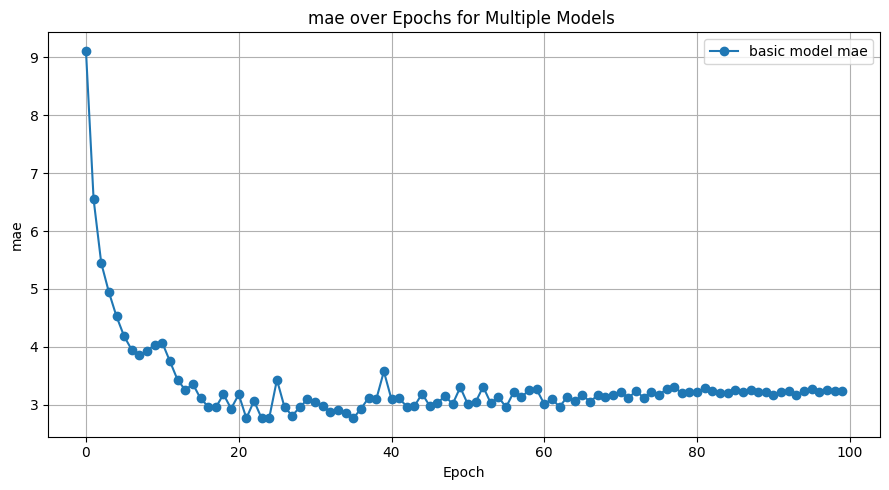

In [ ]:
model = Model(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=1,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(device)

#copiamo i pesi del modello perché così possiamo vedere se stiamo effettivamente modificando model:
initial_state = copy.deepcopy(model.state_dict())


# Edge types con almeno un arco nel training set: prenderemo solo questi per il 
# pre training process:
valid_edge_types = []
for edge_type in data.edge_types:
    edge_index = data[edge_type].edge_index
    if edge_index.size(1) > 0:
        valid_edge_types.append(edge_type)

train_data = next(iter(loader_dict["train"]))
active_edge_types = [et for et in valid_edge_types if et in train_data.edge_types and train_data[et].edge_index.size(1) > 0]


for edge_type in active_edge_types:
    print(f"\nPretraining per edge_type: {edge_type}")
    #model.load_state_dict(initial_state)
    edge_model = EdgePredictionModel(model)
    pretrain_optimizer = torch.optim.Adam(edge_model.parameters(), lr=0.001)
    try:
        pretrain_edge_prediction(edge_model, loader_dict["train"], edge_type=edge_type, optimizer=pretrain_optimizer, epochs=50)
        model.load_state_dict(edge_model.model.state_dict())  # salva pesi aggiornati
        #break
    except ValueError as e:
        print(f"skipping edge_type {edge_type}: {e}")


after_state = model.state_dict()

#verifica se sono cambiati
changed_params = [k for k in initial_state if not torch.equal(initial_state[k], after_state[k])]
print("Parametri modificati:", changed_params if changed_params else "Nessuno è cambiato")


model.load_state_dict(edge_model.model.state_dict())  #in teoria inutile


#down stream
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
epochs = 100
total_steps = epochs * len(loader_dict["train"])
warmup_steps = int(0.1 * total_steps)  # 10% warmup
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
state_dict = None
best_val_metric = -math.inf if higher_is_better else math.inf

#per mantenere la storia dei MAE nel tempo:
val_metr_history = []

for epoch in range(1, epochs + 1):
    train_loss = train(model, optimizer, scheduler)
    val_pred = test(model, loader_dict["val"])
    #val_metrics = task.evaluate(val_pred, val_table)
    val_metrics = custom_evaluate(val_pred, val_table, task.metrics)

    val_metr_history.append(val_metrics[tune_metric])

    print(f"Epoch: {epoch:02d}, Train loss: {train_loss}, Val metrics: {val_metrics}")

    if (higher_is_better and val_metrics[tune_metric] > best_val_metric) or (
            not higher_is_better and val_metrics[tune_metric] < best_val_metric
    ):
        best_val_metric = val_metrics[tune_metric]
        state_dict = copy.deepcopy(model.state_dict())


model.load_state_dict(state_dict)
val_pred = test(model, loader_dict["val"])
val_metrics = custom_evaluate(val_pred, val_table, task.metrics)
print(f"Best Val metrics: {val_metrics}")

test_table = task.get_table("test", mask_input_cols=False)
test_pred = test(model,loader_dict["test"])
test_metrics = custom_evaluate(test_pred, test_table, task.metrics)
print(f"Best test metrics: {test_metrics}")

plot_validation_metrics([val_metr_history], ["basic model"],  metric_name=tune_metric)


# Import a predefined model to use it

In [ ]:
# model.load_state_dict(torch.load('best_model_GAT_head2.pth', map_location=torch.device('cpu')))